In [2]:
import numpy as np

class RecurLayer:
    
    # n_iter controls internal recurrence within one sample. When it is 0, no internal recurrence.
    # External recurrence always happens between samples, if they are forwarded consecutively.
    # Backwarding/updating will reset the context.
    def __init__(self, n_x, n_h, n_iter=1, acti="TANH"):
        assert n_iter > 0
        self.n_x = n_x
        self.n_h = n_h        
        
        self.wx = np.random.uniform(-1, 1, (n_h, n_x)) * 0.1       
        self.wh = np.random.uniform(-1, 1, (n_h, n_h)) * 0.1
        self.bh = np.random.uniform(-1, 1, (n_h, 1)) * 0.1

        # for debugging purpose
        #self.wx = np.ones(shape=(n_h, n_x))       
        #self.wh = np.ones(shape=(n_h, n_h)) 
        #self.bh = np.ones(shape=(n_h, 1)) 
        
        self.acti = Activation(acti)
        self.n_iter = n_iter
        self.n_recur = None
        # initialize input/output and gradients data structure
        self.reset_context()
        
    #              bh
    # x -> (wx) -> + -> a -> (acti) -> -> h     
    #              L- <-(wh)---------J 
    #                                   
    def forward_1sample(self, x):
        #set_trace()
        assert self.n_x == x.size
        self.X.append(x)
        
        s = np.dot(self.wx, x) 
        h = self.H[-1][-1]
        local_H = [] 
        # internal recurrence forward
        for i in range(self.n_iter):
            a = s + np.dot(self.wh, h) + self.bh
            h = self.acti.func(a)
            local_H.append(h)
        
        self.H.append(local_H)
        return h
    
    def forward(self, nx):
        self.n_recur = nx.shape[0]
        # external recurrent forward
        for i in range(self.n_recur):
            h = self.forward_1sample(nx[i])
        
        return h

    def backward_1sample(self, g_y):
        #set_trace()
        assert g_y.size == self.n_h
        g_h = g_y + self.g_h  # plus the g_h from prev backwarding

        x = self.X.pop()
        local_H = self.H.pop()
        h = local_H.pop()
        # internal recurrence backward
        for i in reversed(range(self.n_iter)):
            g_signal = self.acti.grad(h)
            g_a = g_signal * g_h
            self.g_bh += g_a
            self.g_wx += np.outer(g_a, x)
            self.g_x += np.dot(self.wx.T, g_a)
            g_h = np.dot(self.wh.T, g_a)        # compute g_h for next backwarding
        
            if i != 0:                          # older h in internal recurrence
                h = local_H.pop()  
            else:                               # older h from external recurrence. 
                assert local_H == [] and i == 0 # Reach the first internal recurrence pass, no more old internal h
                h = self.H[-1][-1]    # We don't pop it, since it will be used by next backward_1sample pass
                                      # If this is final external recurrence, then h is 0, so it won't hurt.
            self.g_wh += np.outer(g_a, h)
        
        self.g_h = g_h
        return self.g_x

    def backward(self, g_y):
        assert g_y.size == self.n_h
        # external recurrent backward
        self.g_h = self.g_bh = self.g_wh = self.g_wx = self.g_x = 0
        # fake the g_y's from higher layer for every backward op
        g_Y = np.zeros(shape=(self.n_recur, *g_y.shape))
        g_Y[0] = g_y
        for i in range(self.n_recur):
            self.backward_1sample(g_Y[i])
        
        return self.g_x
        
    def update(self, learning=0.01):
        self.wx -= self.g_wx * learning
        self.wh -= self.g_wh * learning
        self.bh -= self.g_bh * learning
        init_h = np.zeros(shape=(self.n_h, 1))
        orig_h = self.H.pop().pop()
        assert (orig_h == init_h).all() and self.H == []
        self.reset_context()
        return
    
    def reset_context(self):
        self.X = []
        init_h = np.zeros(shape=(self.n_h, 1))
        self.H = [[init_h]]
        self.g_h = self.g_bh = self.g_wh = self.g_wx = self.g_x = 0
        self.n_recur = None
        return
        
    def __str__(self):
        s = "\nX is:\n"+str(self.X)
        s += "\nwx is:\n" + str(self.wx)
        s += "\nwh is:\n" + str(self.wh)
        s += "\nbh is:\n" + str(self.bh)
        s += "\nH is:\n"+str(self.H)
        s += "\ng_H is:\n"+str(self.g_h)
        s += "\ng_wx is:\n"+str(self.g_wx)
        s += "\ng_wh is:\n"+str(self.g_wh)
        s += "\ng_bh is:\n"+str(self.g_bh)
        s += "\ng_X is:\n"+str(self.g_x)
        
        return s
        

In [7]:
class RecurNet:
    
    def __init__(self, n_x, n_h, n_y, h_acti="TANH", y_acti="RELU", 
                 n_iter=1, outlayer=None, learning=0.01):

        self.type = "RNN"
        
        n_h = n_h if n_h > 0 else (n_x + n_y) // 2
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        self.recur = RecurLayer(n_x, n_h, n_iter, h_acti)
        self.output = outlayer
        if outlayer is None:
            self.output = PercepLayer(n_h, n_y, y_acti)
        
        self.learning = learning
        return
    
    def forward(self, x):
        h = self.recur.forward(x)
        y = self.output.forward(h)
        return y
    
    def backward(self, g_y):
        g_h = self.output.backward(g_y)
        g_x = self.recur.backward(g_h)
        return g_x

    def forward_1batch(self, X):
        #set_trace()
        n_sample = X.shape[0]
        self.n_sample = n_sample
        Y = np.empty(shape=(n_sample, self.n_y, 1))  
        for i in range(n_sample):
            h = self.recur.forward_1sample(X[i])
            Y[i] = self.output.forward(h)            
            #print(i, h, Y[i])
        
        return Y
    
    def backward_1batch(self, Y):
        n_error = Y.shape[0]
        assert n_error == self.n_sample
        g_X = np.empty(shape=(n_error, self.n_x, 1))  
        # the g_h generated by last recurrence. At beginning, it is 0.
        g_h = np.zeros(shape=(self.n_h, 1))
        for i in reversed(range(n_error)):
            g_s = self.output.backward(Y[i])
            g_X[i] = self.recur.backward_1sample(g_s)
            #print(i, g_h, g_X[i])
        
        return g_X

    def update(self):
        self.output.update(self.learning)
        self.recur.update(self.learning)
        return

    # 1sample is like an image that consists of a squence for training 
    def predict_1sample(self, x):
        n_recur = x.size // self.n_x
        x = x.reshape(n_recur, self.n_x, 1)
        y = self.forward(x)
        self.recur.reset_context()
        return y
    
    def train_1sample(self, x, label):
        #set_trace()
        n_recur = x.size // self.n_x
        x = x.reshape(n_recur, self.n_x, 1)
        self.forward(x)
        self.backward(label)
        self.update()
        return
        
    # 1batch is a sequence of many samples, predicting next one for the sequence 
    def predict_1batch(self, X):
        Y = self.forward_1batch(X)
        self.recur.reset_context()
        return Y[-1]
    
    def train_1batch(self, X, Y):
        #set_trace()
        self.forward_1batch(X)
        self.backward_1batch(Y)
        self.update()
        return
    

In [4]:
%run 'multilayer-perceptron.ipynb'

In [5]:
def run_rnn_test():
    n_x=3; n_h=4; n_class=3
    outlayer = SoftMaxLayer(n_h, n_class)
    rnn = RecurNet(n_x, n_h, n_class, n_iter=1, outlayer=outlayer, h_acti="SIGMOID", learning=0.1)
    X = [
        [1,2,3],
        [2,1,3],
        [3,1,2],
        [3,2,1],
        [1,3,2],
        [2,3,1]
        ]
    Y = [2,2,0,0,1,1]
    X = np.array(X)
    Y = np.array(Y)

    for j in range(40):
#        if j % 10 == 0:
#            print(rnn.recur)
#            print(rnn.output)
            
        for i in range(X.shape[0]):
            rnn.train_1sample(X[i].reshape(-1,1), Y[i])

    X = np.array([[1,2,3],[2,3,1],[3,1,2]])
    for i in range(X.shape[0]):
        predict = rnn.predict_1sample(X[i].reshape(-1,1))
        print("\nPredict: ", X[i], predict)

if __name__  == '__main__':
    pass
    run_rnn_test()
    


Predict:  [1 2 3] 2

Predict:  [2 3 1] 1

Predict:  [3 1 2] 0


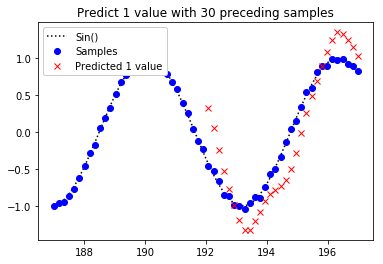

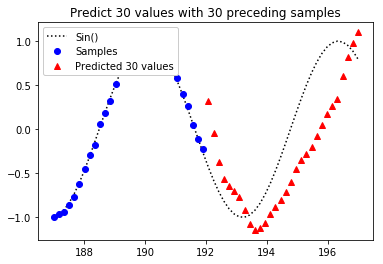

In [107]:
import matplotlib.pylab as plt

def noisize(X):
    Y = X + (np.random.random_sample(X.shape) - 0.5) * 0.1
    return Y

def run_rnn_sine():
    # training data
    n_seq = 500
    seq_len = 30
    scope = 5    # scope < 10
    X = np.linspace(0, 10, seq_len+1)[None, :]
    for i in range(n_seq-1):
        j = np.random.randint(0, 1000)
        X = np.concatenate((X, np.linspace(j, j+scope, seq_len+1)[None, :]))
        
    Label = np.sin(X) 
    Input = noisize(Label)
    
    # build the network
    n_x = 1; n_h= 333; n_y=1
    outlayer = MSELayer(n_h, n_y)
    rnn = RecurNet(n_x, n_h, n_y,
                   outlayer=outlayer, h_acti="TANH", learning=0.0002)
    
    
    Input = Input[:, :seq_len].reshape(n_seq, seq_len, n_x, 1)
    Label = Label[:, 1:].reshape(n_seq, seq_len, n_x, 1)
    
    # training
    n_epoch = 2
    for j in range(n_epoch):
        for i in range(n_seq):
            rnn.train_1batch(Input[i], Label[i])
    
    # testing data
    j = np.random.randint(0, 1000)
    new_len = seq_len * 2
    new_scope = scope * 2
    seq_len = new_len // 2
    X = np.linspace(j, j+new_scope, new_len)
    
    Label = np.sin(X)
    Raw = noisize(Label)
    Input = Raw.reshape(new_len, n_x, 1)
    Output = np.zeros(seq_len)
    
    # predicting
    for i in range(seq_len):
        Output[i] = rnn.predict_1batch(Input[i:(seq_len+i)])

    Newout = Input.copy()
    for i in range(seq_len):
        Newout[seq_len+i][0][0] = rnn.predict_1batch(Newout[i:(seq_len+i)])
    Newout = Newout.reshape(new_len)
    
    # showing
    plt.plot(X, Label, 'k:', label="Sin()")
    plt.plot(X, Raw, 'bo', label="Samples")
    plt.plot(X[seq_len:], Output, 'rx', label="Predicted 1 value")
    leg = plt.legend(loc='upper left')
    leg.get_frame().set_alpha(1)
    plt.title('Predict 1 value with %d preceding samples'%(seq_len,))
    plt.show()
 
    plt.plot(X, Label, 'k:', label="Sin()")
    plt.plot(X[:seq_len], Raw[:seq_len], 'bo', label="Samples")
    plt.plot(X[seq_len:], Newout[seq_len:], 'r^', label="Predicted %d values"%(seq_len,))
    leg = plt.legend(loc='upper left')
    leg.get_frame().set_alpha(1)
    plt.title('Predict %d values with %d preceding samples'%(seq_len, seq_len))
    plt.show()
     
if __name__ == "__main__":
    np.seterr(all="raise")
    run_rnn_sine()

In [ ]:

%run 'mnist.ipynb'
def run_rnn_mnist():
    n_x = 28*4; n_h= 28*7+1; n_class=10
    outlayer = SoftMaxLayer(n_h, n_class)
    rnn = RecurNet(n_x, n_h, n_class,
                   outlayer=outlayer, h_acti="TANH", learning=0.001)
    mnist = MNIST(rnn, folder="../convolution-network")
    for i in range(5):
        mnist.train(-1)
        accuracy = mnist.test(-1)
        print("\nAccuracy of epoch {} is {}".format(i, accuracy))
    return mnist

mnist = None
if __name__  == '__main__':
    pass 
    mnist = run_rnn_mnist()


Accuracy of epoch 0 is 0.9282

Accuracy of epoch 1 is 0.9463

Accuracy of epoch 2 is 0.9574

Accuracy of epoch 3 is 0.9617
